In [1]:
pip install tensorflowjs

In [2]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
import kagglehub
import PIL.Image
import shutil
import tensorflowjs as tfjs
import tensorflow as tf

In [3]:
path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")
print("Path to dataset files:", path)

dataset_dir = f"{path}/PetImages"


100%|██████████| 775M/775M [00:10<00:00, 78.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/bhavikjikadara/dog-and-cat-classification-dataset/versions/1


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Total gambar: 24998
Gambar korup: 4

Detail Gambar Korup:
/root/.cache/kagglehub/datasets/bhavikjikadara/dog-and-cat-classification-dataset/versions/1/PetImages/Cat/4833.jpg
/root/.cache/kagglehub/datasets/bhavikjikadara/dog-and-cat-classification-dataset/versions/1/PetImages/Cat/7968.jpg
/root/.cache/kagglehub/datasets/bhavikjikadara/dog-and-cat-classification-dataset/versions/1/PetImages/Cat/8470.jpg
/root/.cache/kagglehub/datasets/bhavikjikadara/dog-and-cat-classification-dataset/versions/1/PetImages/Dog/1308.jpg

Gambar dengan Ukuran Kecil:
/root/.cache/kagglehub/datasets/bhavikjikadara/dog-and-cat-classification-dataset/versions/1/PetImages/Cat/5673.jpg: 4x4


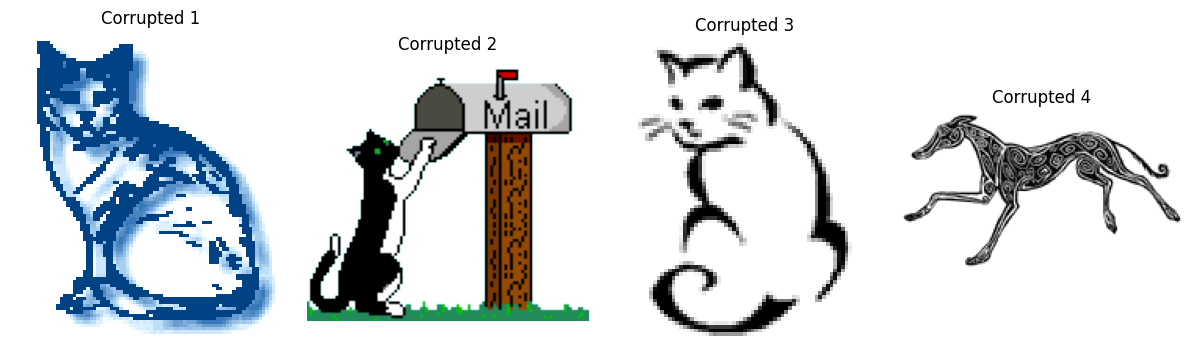

In [4]:
def check_image_quality(dataset_dir):
    corrupted_images = []
    total_images = 0
    size_issues = []

    for category in ['Cat', 'Dog']:
        category_path = os.path.join(dataset_dir, category)

        for filename in os.listdir(category_path):
            try:
                filepath = os.path.join(category_path, filename)

                if not filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                    continue

                with PIL.Image.open(filepath) as img:
                    width, height = img.size
                    img_array = np.array(img)
                    if img_array.size == 0 or np.mean(img_array) < 10:
                        corrupted_images.append(filepath)
                    if width < 32 or height < 32:
                        size_issues.append((filepath, width, height))

                total_images += 1

            except Exception as e:
                corrupted_images.append(filepath)

    print(f"Total gambar: {total_images}")
    print(f"Gambar korup: {len(corrupted_images)}")
    print("\nDetail Gambar Korup:")
    for img in corrupted_images[:10]:
        print(img)

    print("\nGambar dengan Ukuran Kecil:")
    for img, w, h in size_issues[:10]:
        print(f"{img}: {w}x{h}")

    plt.figure(figsize=(15,5))
    for i, img_path in enumerate(corrupted_images[:5]):
        try:
            img = PIL.Image.open(img_path)
            plt.subplot(1,5,i+1)
            plt.imshow(img)
            plt.title(f"Corrupted {i+1}")
            plt.axis('off')
        except:
            pass
    plt.tight_layout()
    plt.show()

    return corrupted_images, size_issues
corrupted, small_images = check_image_quality(f"{path}/PetImages")

In [5]:
def clean_and_reorganize_dataset(dataset_dir):
    corrupted_count = 0
    small_image_count = 0
    clean_dataset_dir = os.path.join(os.path.dirname(dataset_dir), 'CleanPetImages')
    os.makedirs(clean_dataset_dir, exist_ok=True)

    for category in ['Cat', 'Dog']:
        category_clean_path = os.path.join(clean_dataset_dir, category)
        os.makedirs(category_clean_path, exist_ok=True)

        source_category_path = os.path.join(dataset_dir, category)

        for filename in os.listdir(source_category_path):
            filepath = os.path.join(source_category_path, filename)

            try:
                with PIL.Image.open(filepath) as img:
                    width, height = img.size
                    img_array = np.array(img)
                    if width >= 32 and height >= 32 and img_array.size > 0 and np.mean(img_array) >= 10:
                        shutil.copy(filepath, os.path.join(category_clean_path, filename))
                    else:
                        small_image_count += 1

            except Exception as e:
                corrupted_count += 1

    print(f"Gambar korup dihapus: {corrupted_count}")
    print(f"Gambar berukuran kecil dihapus: {small_image_count}")

    return clean_dataset_dir

clean_path = clean_and_reorganize_dataset(f"{path}/PetImages")


Gambar korup dihapus: 0
Gambar berukuran kecil dihapus: 5


In [6]:
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    clean_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    clean_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

Found 19995 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


In [7]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)
base_model.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
model = Sequential([
    base_model,
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

In [11]:
# Custom Callback
class AccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') and logs.get('val_accuracy') > 0.96:
            print(f"\nTarget akurasi tercapai di epoch {epoch+1}")
            self.model.stop_training = True

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=8,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=4,
    min_lr=0.000001
)

accuracy_callback = AccuracyCallback()

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr, accuracy_callback],
    verbose=1
)

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 196s 306ms/step - accuracy: 0.8696 - loss: 0.2977 - val_accuracy: 0.8737 - val_loss: 0.2830 - learning_rate: 1.0000e-04
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 185s 294ms/step - accuracy: 0.8817 - loss: 0.2688 - val_accuracy: 0.8900 - val_loss: 0.2531 - learning_rate: 1.0000e-04
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 202s 294ms/step - accuracy: 0.8874 - loss: 0.2588 - val_accuracy: 0.8784 - val_loss: 0.2746 - learning_rate: 1.0000e-04
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 202s 294ms/step - accuracy: 0.8980 - loss: 0.2396 - val_accuracy: 0.8842 - val_loss: 0.2664 - learning_rate: 1.0000e-04
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 190s 303ms/step - accuracy: 0.9048 - loss: 0.2250 - val_accuracy: 0.8882 - val_loss: 0.2643 - learning_rate: 1.0000e-04
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 196s 293ms/step - accuracy: 0.9044 - loss: 0.2204 - val_accuracy: 0.8922 - val_loss: 0.2372 - learning_rate: 1.0000e-04
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 

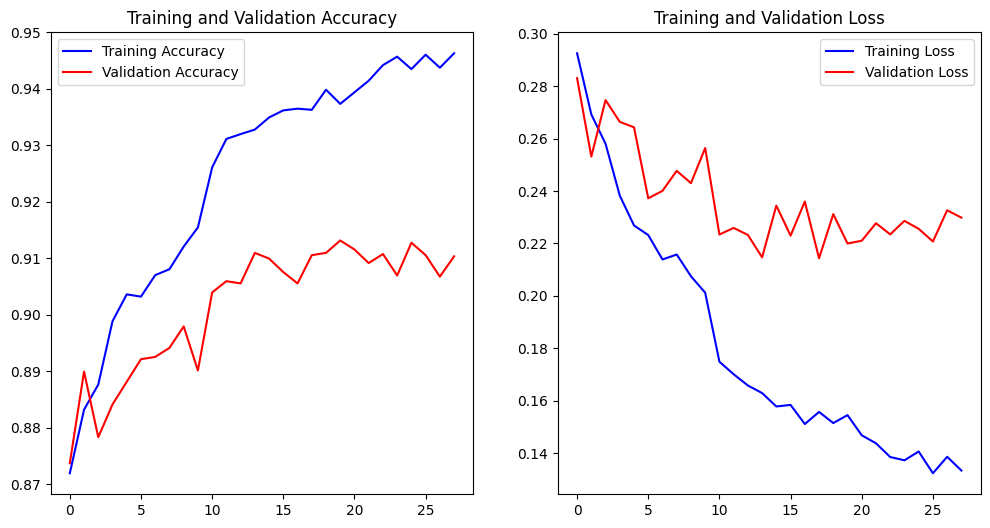

In [12]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_history(history)


In [13]:
"""## Konversi Model

Menyimpan model menjadi format .h5.
"""

model.save("model.h5")

"""### Konversi TFJS

Konversi model menjadi format TFJS.
"""

!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

"""### Konversi SavedModel

Konversi menjadi saved_model.
"""

save_path = os.path.join("models/klasifikasi_gambar/1/")
tf.saved_model.save(model, save_path)

"""### Konversi TF-Lite

Konversi model menjadi format TFLITE dan menyimpan label.txt.
"""

# Load the Keras model
model_TFLITE = tf.keras.models.load_model('model.h5')

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model_TFLITE)
tflite_model = converter.convert()

# Save the converted model to a file
with open("converted_model.tflite", "wb") as f:
    f.write(tflite_model)

# Buat konten yang akan ditulis ke dalam file
content = """Late_blight
Septoria_leaf_spot
Tomato_Yellow_Leaf_Curl_Virus
healthy"""

# Tentukan path dan nama file
file_path = "/content/klasifikasiGambar.txt"

# Tulis konten ke dalam file
with open(file_path, "w") as file:
    file.write(content)

"""Menjadikan zip agar dapat di download ke local device."""

# Specify the folder to zip
folder_modles = '/content/models'
folder_tfjs_model = '/content/tfjs_model'

# Specify the output zip file name (without .zip extension)
output_modles= '/content/models'
output_tfjs_model = '/content/tfjs_model'

# Zip the folder
shutil.make_archive(output_modles, 'zip', folder_modles)
shutil.make_archive(output_tfjs_model, 'zip', folder_tfjs_model)

!pip freeze > requirements.txt

2024-12-09 14:58:16.934998: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733756297.005375   25208 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733756297.020659   25208 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


Saved artifact at '/tmp/tmpeuup11lx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139842498021328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139842498026256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139842498030832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139842498032768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139842498034528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139842498056032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139842498055504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139842498052512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139842498057792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139842498052864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1398424980588